In [8]:
import pandas as pd
import geemap, ee
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [10]:
coef = pd.read_csv('assets/dmsp_coeffs.csv')

def get_coefs(img, coefdata=coef):
    imgID = img.id().getInfo()
    idx = coefdata['satellite']+coefdata['year'].astype(str)==imgID
    return coefdata.loc[idx, ['c0','c1','c2']].values[0]

def calibrate_img(img):
    c0, c1, c2 = get_coefs(img)
    return img.expression("c0 + (c1 * X) + (c2 * X**2)", {'X':img, 'c0':c0, 'c1':c1, 'c2':c2})

def clip_img(img, upper_thresh=63, upper_set=63, lower_thresh=6, lower_set=0):
    return img.where(img.gt(upper_thresh),upper_set).where(img.lte(lower_thresh),lower_set)

def calibrate_and_clip(img):
    return clip_img(calibrate_img(img))

In [11]:
dmsp1999F12 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F152007").select("stable_lights")
dmsp1999F14 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F162007").select("stable_lights")
dmsp1999F12_calbr = dmsp1999F12.where(dmsp1999F12.gt(63),63).where(dmsp1999F12.lte(6),0)

In [12]:
aoi = ee.FeatureCollection("users/amirhkiani1998/teh")

In [13]:
myMap = geemap.Map()
myMap.addLayer(dmsp1999F12.clip(aoi))
myMap.centerObject(aoi)
myMap

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [14]:
myMap = geemap.Map()
# myMap.addLayer(dmsp1999F12_clip.clip(aoi))
left_layer = geemap.ee_tile_layer(dmsp1999F12_calbr.clip(aoi), {}, "Clipped")
right_layer = geemap.ee_tile_layer(dmsp1999F12.clip(aoi), {}, "Not Clipped")

myMap.split_map(left_layer, right_layer)

myMap.centerObject(aoi)
myMap

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [15]:
tehranNumpy = geemap.ee_to_numpy(dmsp1999F12, region=aoi)
tehranNumpyCalbr = geemap.ee_to_numpy(dmsp1999F12_calbr, region=aoi)

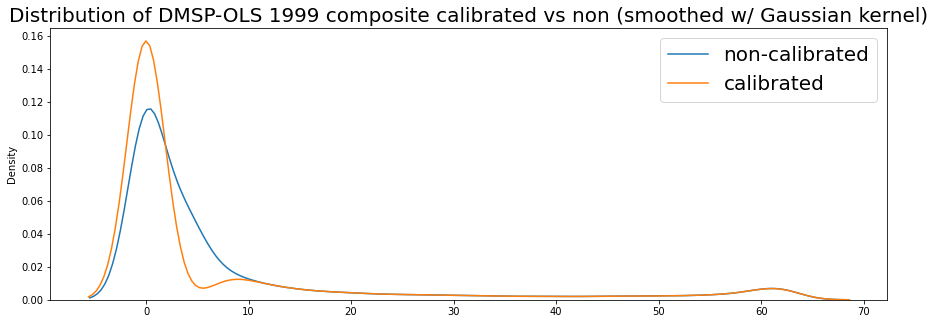

In [16]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(tehranNumpy.flatten(), label='non-calibrated',legend=True, ax=ax)
sns.kdeplot(tehranNumpyCalbr.flatten(), label='calibrated',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Distribution of DMSP-OLS 1999 composite calibrated vs non (smoothed w/ Gaussian kernel)', fontsize=20);

In [17]:
dmsp1999F12_arr = geemap.ee_to_numpy(dmsp1999F12, region=aoi)
dmsp1999F14_arr = geemap.ee_to_numpy(dmsp1999F14, region=aoi)

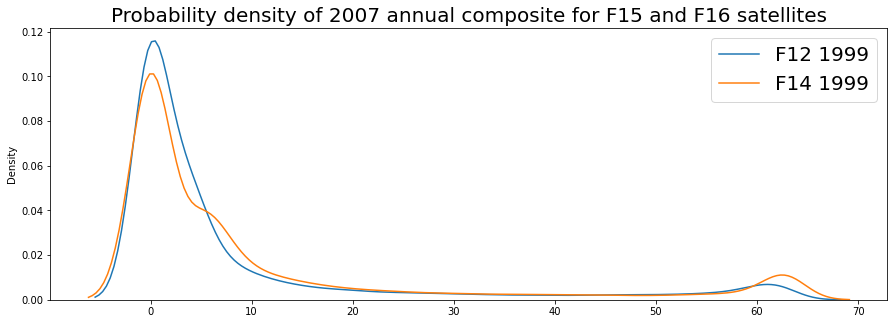

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1999F12_arr.flatten(), label='F12 1999',legend=True, ax=ax)
sns.kdeplot(dmsp1999F14_arr.flatten(), label='F14 1999',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites', fontsize=20);

In [19]:
dmsp1999F14_calbr = calibrate_and_clip(dmsp1999F14)
dmsp1999F14_arr_calbr = geemap.ee_to_numpy(dmsp1999F14_calbr, region=aoi)
dmsp1999F12_arr_calbr = geemap.ee_to_numpy(dmsp1999F12_calbr, region=aoi)

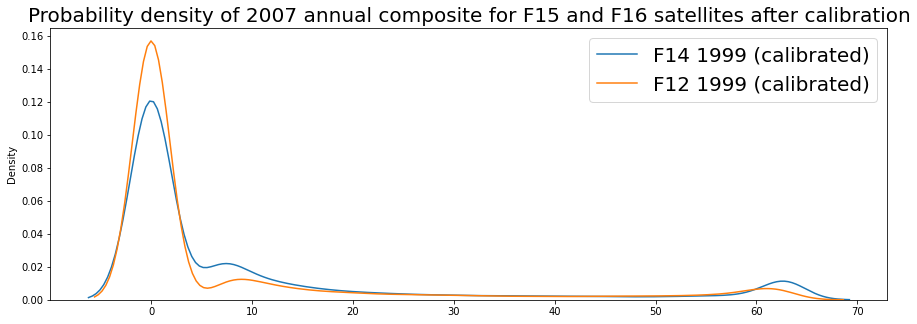

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.kdeplot(dmsp1999F14_arr_calbr.flatten(), label='F14 1999 (calibrated)',legend=True, ax=ax)
sns.kdeplot(dmsp1999F12_arr_calbr.flatten(), label='F12 1999 (calibrated)',legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title('Probability density of 2007 annual composite for F15 and F16 satellites after calibration', fontsize=20);

In [21]:
viirs2015 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)
viirs2019 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2019-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)

viirs_15_tile = geemap.ee_tile_layer(viirs2015, {}, 'Jul-Dec 2015', opacity=0.75)
viirs_19_tile = geemap.ee_tile_layer(viirs2019, {}, 'Jul-Dec 2019', opacity=0.75)

# initialize our map
map2 = geemap.Map()
map2.centerObject(roi, 9)
map2.split_map(left_layer=viirs_15_tile, right_layer=viirs_19_tile)
map2.addLayerControl()
map2

NameError: name 'roi' is not defined

# Start the code

## Import vital libraries

In [2]:
import pandas as pd
import geemap, ee
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

## Get VIIRS data <span style='font-size:14px'>(2012-04-01T00:00:00 - 2021-05-01T00:00:00)</span>

In [17]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select('avg_rad')
iran = ee.FeatureCollection("users/amirhkiani1998/iran")

In [4]:
provinces = pd.read_csv("assets/iran/Province/names_info.csv")
provinces

,name,short_name,full_name,primary_name
0,خوزستان,khz,Khoozestan,خوزستان
1,خراسان شمالي,khr_north,Khorasan Shomali,خراسان شمالی
2,زنجان,znj,Zanjan,زنجان
3,سمنان,smn,Semnan,سمنان
4,سيستان و بلوچستان,sisblch,Sistan Va Baloochestan,سیستان و بلوچستان
5,فارس,frs,Fars,فارس
6,قزوين,ghz,Ghazvin,قزوین
7,قم,ghm,Ghom,قم
8,گلستان,gls,Golestan,گلستان
9,گيلان,gil,Gilan,گیلان


### Make Automation Function

In [4]:
def getData(city_name, reducer = ee.Reducer.mean(), reducer_to_save = "mean"):
    city_name = city_name.strip()
    city_geom = ee.FeatureCollection("users/amirhkiani1998/" + city_name)
    def getCityAvgRad(img):
        return img.reduceRegions(reducer= reducer, collection = city_geom, scale = 500)
    def getDate(img):
        return img.set('date', img.date().format())
    reduced = viirs.map(getCityAvgRad)
    dates = viirs.map(getDate)
    listMean = reduced.flatten().reduceColumns(ee.Reducer.toList(1), [reducer_to_save]).values().getInfo()
    listDates = dates.reduceColumns(ee.Reducer.toList(1), ["date"]).values().getInfo()
    dataframe = pd.DataFrame()
    dataframe["dates"] = np.asarray(listDates).squeeze()
    dataframe[reducer_to_save] = np.asarray(listMean).squeeze()
    dataframe["city_name"] = city_name
    dataframe.to_csv( "assets/iran/Province/" + name + "/" + name + "_" + reducer_to_save +  ".csv")
    return(dataframe)

def mergeDataframes(dataframe_1, dataframe_2):
    return(dataframe_1.merge(right= dataframe_2, on = "date", how = "inner"))
    

#### Getting all Provinces Dataframe

In [ ]:
provinces_short_name = provinces.short_name
dataframeNew = pd.DataFrame()

ignoreList = []
errorIgnoreList = [
    "islands"
]
for name in provinces_short_name:
    name = name.strip()
    if name in ignoreList or name in errorIgnoreList:
        continue
    extractedProvinceData = getData(name, ee.Reducer.stdDev(), "stdDev")
    if(dataframeNew.shape == (0,0)):
        dataframeNew = extractedProvinceData
    else:
        dataframeNew = pd.concat([dataframeNew, extractedProvinceData])
    extractedProvinceData.to_csv( "assets/iran/Province/" + name + "/" + name + "_std.csv")
    print(" done", sep="")
    print()


### Save the dataframe

In [ ]:
dataframeNew.to_csv("assets/iran/Province/whole_mean.csv")

# Get Latitude and Longitiude in VIIRS

## Make map function for getting Long. and Lat.

In [110]:
def addLongLatMap(image):
    return image.addBands(ee.Image.pixelLonLat())
def addLongLat(ImageCollection):
    return ImageCollection.map(addLongLatMap)

In [49]:
viirsWithLongLat = viirs.map(addLongLatMap)


In [61]:
viirsWithLongLatList = viirsWithLongLat.toList(100)


In [9]:
tehran = ee.FeatureCollection("users/amirhkiani1998/teh")


## Making the function for getting numpy array

In [114]:

def imageToNumpy(image, provinceShortName, scale = 100):
    date = datetime.datetime.fromisoformat(image.date().format().getInfo())
    dateString = str(date.year) + "-" + str(date.month) + "-" + str(date.day)
    print(dateString, provinceShortName, "start", sep="|")
    province = ee.FeatureCollection(
        "users/amirhkiani1998/" + provinceShortName)
    array = image.reduceRegion(
        reducer=ee.Reducer.toList(), geometry=province, scale=scale)
    array = array.getInfo()
    directoryPath = "assets/iran/Province/" + provinceShortName
    if(not os.path.isdir(directoryPath + "/numpy_arrays")):
        os.mkdir(directoryPath + "/numpy_arrays")
    np.save(directoryPath + "/numpy_arrays/" + provinceShortName +
            "_" + dateString + ".npy", np.array(array))
    print(dateString, provinceShortName, "done", sep="|")
    return True


In [115]:
shortNames = provinces.short_name


In [1]:
for provinceName in shortNames:
    provinceName = provinceName.strip()
    for i in range(88):
        image = ee.Image(viirsWithLongLatList.get(i))
        imageToNumpy(image, provinceShortName=provinceName,  scale=500)


# Getting data from GHSL (Global Human Settlement Layer)

In [104]:
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').select("smod_code")


In [107]:
ghslTehran = ghsl.first().gte(0)


In [50]:
myMap = geemap.Map()
myMap.addLayer(ghslTehran, {}, 'Degree of Urbanization')
myMap.centerObject(iran)
myMap


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [126]:
def makingGreaterThatTwo(image):
    return image.gt(2)

def getProvinceGHSL(province, image, scale = 500):
    date = datetime.datetime.fromisoformat(image.date().format().getInfo())
    dateString = str(date.year) + "-" + str(date.month) + "-" + str(date.day)
    print(dateString, province, "start", sep="|")
    image = image.gt(2)
    image = image.addBands(ee.Image.pixelLonLat())
    province = province.strip()
    provinceImage = ee.FeatureCollection("users/amirhkiani1998/" + province)
    array = np.array(image.reduceRegion(reducer=ee.Reducer.toList(), geometry=provinceImage, scale=scale).getInfo())
    directoryPath = "assets/iran/Province/" + \
        province + "/numpy_arrays/ghsl_" + province + "_" + dateString + ".npy"
    np.save(directoryPath, array)
    print(province , "done", sep="|")


## start getting the values for being built-up

In [139]:
ghslSize = ghsl.size().getInfo()
ghslWithLatLang = addLongLat(ghsl)
ghslWithLatLangList = ghslWithLatLang.toList(ghslSize)

provinces_short_name = provinces.short_name
for i in range(ghslSize):
    image = ee.Image(ghslWithLatLangList.get(i))
    for province in provinces_short_name:
        getProvinceGHSL(province, image)


1975-1-1| khz|start
khz|done
1975-1-1| khr_north|start
khr_north|done
1975-1-1| znj|start
znj|done
1975-1-1| smn|start
smn|done
1975-1-1| sisblch|start
sisblch|done
1975-1-1| frs|start
frs|done
1975-1-1| ghz|start
ghz|done
1975-1-1| ghm|start
ghm|done
1975-1-1| gls|start
gls|done
1975-1-1| gil|start
gil|done
1975-1-1| lrs|start
lrs|done
1975-1-1| mzn|start
mzn|done
1975-1-1| mrk|start
mrk|done
1975-1-1| hrmz|start
hrmz|done
1975-1-1| hmd|start
hmd|done
1975-1-1| yzd|start
yzd|done
1975-1-1| krd|start
krd|done
1975-1-1| krm|start
krm|done
1975-1-1| krmsh|start
krmsh|done
1975-1-1| khgbah|start
khgbah|done
1975-1-1| khr_razavi|start
khr_razavi|done
1975-1-1| alb|start
alb|done
1975-1-1| ard|start
ard|done
1975-1-1| azr_east|start
azr_east|done
1975-1-1| azr_west|start
azr_west|done
1975-1-1| bch|start
bch|done
1975-1-1| chbkh|start
chbkh|done
1975-1-1| ilm|start
ilm|done
1975-1-1| isf|start
isf|done
1975-1-1| teh|start
teh|done
1975-1-1| khr_south|start
khr_south|done
1975-1-1| islands|s

In [140]:
dictionary = np.load("assets/iran/Province/khz/numpy_arrays/ghsl_khz_1975-1-1.npy", allow_pickle=True)[()]
pd.DataFrame(dictionary)

,latitude,longitude,smod_code
0,32.989945,48.274669,0
1,32.989945,48.280232,0
2,32.989945,48.285795,0
3,32.989945,48.291359,0
4,32.989945,48.296922,0
...,...,...,...
256956,29.888333,48.707407,0
256957,29.888333,48.712857,0
256958,29.888333,48.718307,0
256959,29.884063,48.706110,0
